In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models, similarities

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/cleaned.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head()

,rid,sid,app,review,sentiment,aspect,aspect_polarity,cleaned,text
0,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
1,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
2,10,1,Google Play Store/BiP,Her güncellemede daha da kötüleşen Turkcell in...,Negative,Turkcell,0,güncellemede kötüleşen Turkcell in ara ara ken...,Turkcell güncellemede kötüleşen Turkcell in ar...
3,13,1,Google Play Store/BiP,BiP’ten aranmıyor yardım,Negative,BiP’ten,0,BiPten aranmıyor yardım,BiP’ten BiPten aranmıyor yardım
4,17,1,Google Play Store/BiP,Bu yorumum kesinlikle uygulamanın daha çok gel...,Positive,BİP,2,yorumum uygulamanın gelişmesi kulanıcıya erişi...,BİP yorumum uygulamanın gelişmesi kulanıcıya e...


In [5]:
df["text"] = df["aspect"] + " " + df["cleaned"]

In [6]:
X = df["text"]
y = df["aspect_polarity"]

In [7]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(split_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [8]:
df_train, df_validation, df_test = train_validate_test_split(df, split_size=0.9)

In [9]:
X_train = df_train["text"]
y_train = df_train["aspect_polarity"]

In [10]:
X_valid = df_validation["text"]
y_valid = df_validation["aspect_polarity"]

In [11]:
X_test = df_test["text"]
y_test = df_test["aspect_polarity"]

In [12]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [13]:
lr = LogisticRegression()
lr_cv_train_start = time.time()
lr.fit(X_train_cv, y_train)
lr_cv_train_time = time.time() - lr_cv_train_start
print(f"Logistic Regression + CV Train Time = {lr_cv_train_time:.4f}")

Logistic Regression + CV Train Time = 9.4875


In [14]:
lr_cv_pred_train = lr.predict(X_train_cv)
lr_cv_test_start = time.time()
lr_cv_pred_test = lr.predict(X_test_cv)
lr_cv_test_time = time.time() - lr_cv_test_start

lr_cv_train_score = accuracy_score(lr_cv_pred_train, y_train)
lr_cv_test_score = accuracy_score(lr_cv_pred_test, y_test)
print(f"Logistic Regression + CV Train Score = {lr_cv_train_score * 100:.4f}%")
print(f"Logistic Regression + CV Test Score = {lr_cv_test_score * 100:.4f}%")
print(f"Logistic Regression + CV Test Time = {lr_cv_test_time:.4f}")

Logistic Regression + CV Train Score = 89.4801%
Logistic Regression + CV Test Score = 83.0414%
Logistic Regression + CV Test Time = 0.0024


In [15]:
lr_cv_precision_score = precision_score(y_test, lr_cv_pred_test, average='macro')
lr_cv_f1_score = f1_score(y_test, lr_cv_pred_test, average='macro')
lr_cv_recall_score = recall_score(y_test, lr_cv_pred_test, average='macro')
lr_cv_accuracy_score = accuracy_score(y_test, lr_cv_pred_test)

print(f"Logistic Regression + CV Precision Score = {lr_cv_precision_score * 100:.4f}%")
print(f"Logistic Regression + CV F1 Score = {lr_cv_f1_score * 100:.4f}%")
print(f"Logistic Regression + CV Recall Score = {lr_cv_recall_score * 100:.4f}%")
print(f"Logistic Regression + CV Accuracy Score = {lr_cv_accuracy_score * 100:.4f}%")

Logistic Regression + CV Precision Score = 79.0109%
Logistic Regression + CV F1 Score = 69.3472%
Logistic Regression + CV Recall Score = 66.2941%
Logistic Regression + CV Accuracy Score = 83.0414%


In [16]:
print(classification_report(y_test, lr_cv_pred_test, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      4508
     Neutral       0.71      0.27      0.40       421
    Positive       0.80      0.84      0.82      3179

    accuracy                           0.83      8108
   macro avg       0.79      0.66      0.69      8108
weighted avg       0.83      0.83      0.82      8108



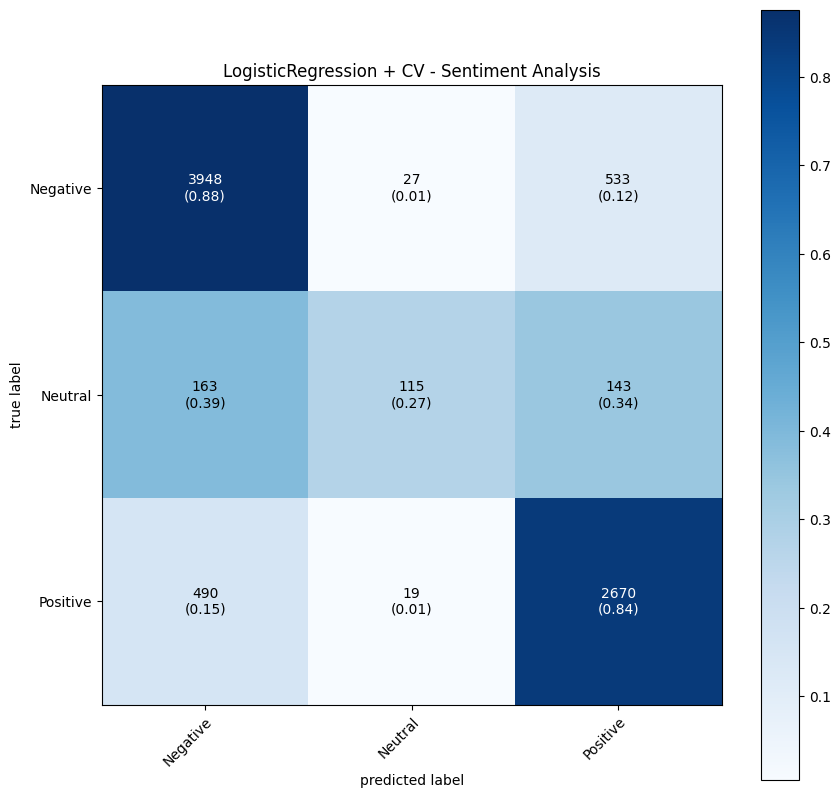

In [17]:
lr_cm = confusion_matrix(y_test, lr_cv_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lr_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"], figsize=(10, 10))
plt.title("LogisticRegression + CV - Sentiment Analysis")
plt.savefig("./output/logisticregression_cv.png")
plt.show()